### Things to do
- Show a correlation matrix for the engineered dataset
- Investigate StreamLit
- Make separate python files
- Make a GitHub repo and upload files

In [11]:
# All imports that will be needed in this notebook

# Each section is delineated with Markdown cells with large titles. If a modification is made in one section,
# it is not necessary to rerun any of the previous sections.

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.lines as lines
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
import seaborn as sns

# Read and process the file

In this section, only the first cell needs to be run to proceed. The rest of the cells provide information about the dataset, but they are not necessary to proceed.

In [12]:
def read_and_process():
    df = pd.read_csv("OnlineRetail.csv",encoding='Windows-1252')

    # Convert the InvoiceDate column to a datetime
    # This cell take a long time for some reason.
    df["InvoiceDate"] = df["InvoiceDate"].apply(pd.to_datetime)

    # Add a column for the total order size
    df["OrderSize"] = df["Quantity"] * df["UnitPrice"]
    
    return df

df = read_and_process()

In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,OrderSize
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [14]:
df.shape

(541909, 9)

In [15]:
# Missing CustomerID and Description for some, all values presents for other fields.
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
OrderSize           0
dtype: int64

In [16]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
OrderSize             float64
dtype: object

In [17]:
# Number of unique products (indicated by description).
len(df["Description"].unique())

4224

Correlation. OrderSize (number of an item in an order) and Quantity are highly correlated, as would be expected. OrderSize and UnitPrice are weakly inversely correlated, indicating that customers tend to buy fewer of an item if there they are more expensive. This is also not a surprise. CustomerID is not correlated to the other features.

TODO: Convert InvoiceDate to a form which can be correlated with other variables.

/var/folders/nk/t6dm1rpx1vz92p_03bt_z94h0000gn/T/ipykernel_8213/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

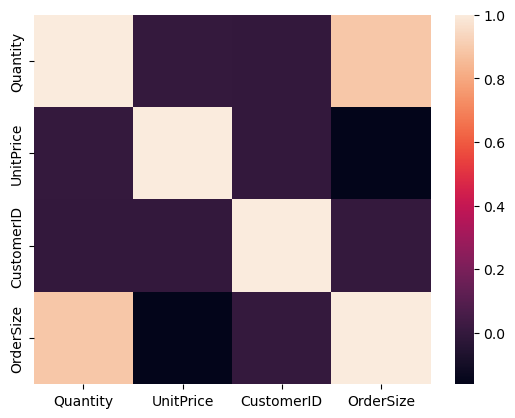

In [18]:
sns.heatmap(df.corr())

# Build a customer-indexed dataframe

To proceed, run the first cell and the second-to-last cell in this section. The other cells are informational.

The first cell builds a customer-indexed dataframe with engineered features. The last cell normalizes the dataframe for use with clustering. The intermediate cells show some information about the data, which is better presented before normalization.

In [19]:
# I suspect that the logarithm of total spending will be a better feature for clustering than absolute
# spending amount, since with absolute spending amount, the clustering will be dominated by outliers.

# (Near)-zero and negative total spending amounts are mapped to 0 so as to avoid null values.
def logspend(x):
    if x <= 1:
        # We choose x <= 1 instead of x <= 0 because some customers have positive reported spending
        # that is within rounding error of 0.
        return 0
    return math.log(x)

def build_customers():

    customers = pd.DataFrame({"CustomerID":df["CustomerID"].unique()})
    customers = customers[customers["CustomerID"].notnull()]
    
    # Earliest and latest order
    customers["EarliestOrder"] = list(df.groupby("CustomerID").min()["InvoiceDate"].astype(int))
    customers["LatestOrder"] = list(df.groupby("CustomerID").max()["InvoiceDate"].astype(int))

    # On spending, we will calculated total amount and the logarithm. Special flags are kepts for customers who did
    # not spend anything and spent a negative amount (i.e. net return)
    customers["TotalSpent"] = list(df.groupby("CustomerID").sum()["OrderSize"])
    customers["LogSpent"] = customers["TotalSpent"].apply(logspend)
    customers["NoSpent"] = (customers["TotalSpent"]<1) & (customers["TotalSpent"]>-1).astype(int)
    customers["NetReturn"] = (customers["TotalSpent"]<-1).astype(int)

    # Number of unique products bought by the customer and number of unique orders
    customers["UniqueProducts"] = list(df.groupby("CustomerID").nunique()["Description"])
    customers["NumOrders"] = list(df.groupby("CustomerID").count()["InvoiceDate"])
    # InvoiceDate is a date and time. I am assuming that unique orders can be differentiated by distinct timestamps.
    customers["UniqueOrders"] = list(df.groupby("CustomerID").nunique()["InvoiceDate"])

    # Country will be represented with one-hot encoding.
    customers["Country"] = list(df.groupby("CustomerID").min()["Country"])
    customers = pd.get_dummies(customers)

    # Drop columns no longer desired
    customers.drop(columns=["CustomerID","TotalSpent"],inplace=True)
    
    return customers

customers = build_customers()

/var/folders/nk/t6dm1rpx1vz92p_03bt_z94h0000gn/T/ipykernel_8213/2079394684.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  customers["TotalSpent"] = list(df.groupby("CustomerID").sum()["OrderSize"])


In [20]:
customers.head()

,EarliestOrder,LatestOrder,LogSpent,NoSpent,NetReturn,UniqueProducts,NumOrders,UniqueOrders,Country_Australia,Country_Austria,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
0,1295344860000000000,1295345820000000000,0.000000,True,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1291733820000000000,1323273120000000000,8.368693,False,0,103,182,7,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1292526540000000000,1316956380000000000,7.494007,False,0,22,31,4,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1321869060000000000,1321869060000000000,7.471676,False,0,73,73,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1296662460000000000,1296662460000000000,5.812338,False,0,17,17,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# 4372 unique customers and 46 features.
customers.shape

(4372, 45)

<Axes: >

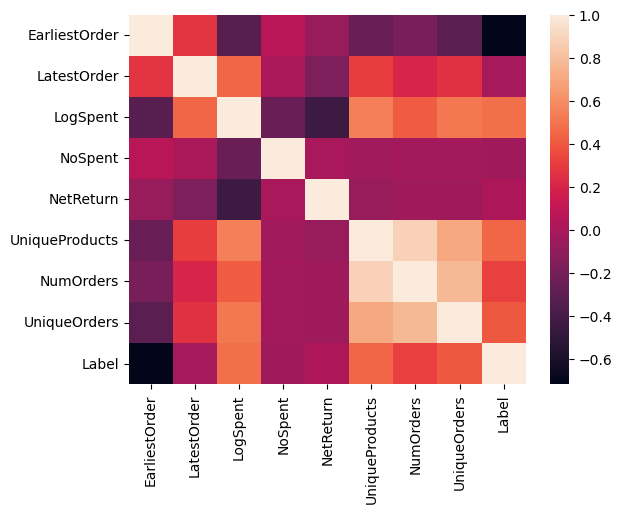

In [44]:
no_country_columns = [c for c in customers.columns if c[:7]!="Country"]
sns.heatmap(customers[no_country_columns].corr())

Relationship between total orders and number of unique products. Also notice that there are a few super-customers who make many orders.

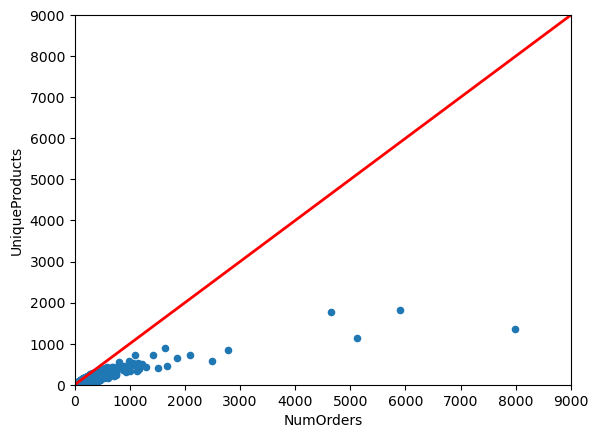

In [22]:
customers.plot.scatter(x="NumOrders",y="UniqueProducts")
plt.xlim([0,9000])
plt.ylim([0,9000])
plt.plot([0, 9000], [0, 9000], color='red', linestyle='-', linewidth=2)
plt.show()

Relationship between total orders and number of unique orders.

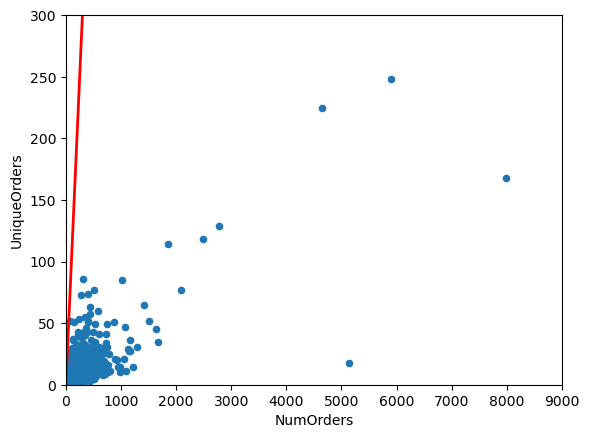

In [23]:
customers.plot.scatter(x="NumOrders",y="UniqueOrders")
plt.xlim([0,9000])
plt.ylim([0,300])
plt.plot([0, 9000], [0, 9000], color='red', linestyle='-', linewidth=2)
plt.show()

Normalize the data set (rescale so all features have mean 0 and standard deviation 1).

There are many one-hot encoded country columns, which I don't think should be allowed to have too great an influence on the clustering. Therefore, I am rescaling those so that those columns have a standard deviation of 0.1. That approach is suggested [here](https://stats.stackexchange.com/questions/226769/weighted-feature-clustering-e-g-kmeans). The size of this rescaling is the product of guesswork.

In [24]:
customers=(customers-customers.mean())/customers.std()
for c in customers.columns:
    if c[:7]=="Country":
        customers[c] *= 0.1

# K-Means Clustering

Eventually I would like to redo the clustering and creation of the customer-indexed dataset to incorporate data only before a cutoff date. Then I want to try to predict the sales by customer after the cut-off date, and I want to see if the cluster created in this section helps us do so. For this task, only the second cell in this section will be needed.

In [25]:
# Apply elbow curve
# This is put in a function to save time when running all cells

def elbow():
    max_clusters = 100

    inertias = []
    for i in range(1,max_clusters+1):
        kmeans = KMeans(n_clusters=i, n_init=1)
        kmeans.fit(customers)
        inertias.append(kmeans.inertia_)
        # Track progress since this is a little slow
        if i%10 == 0:
            print(i)

    plt.plot(range(1,max_clusters+1), inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()
#elbow()

# The elbow method shows two elbows: one at 3 clusters and another around 42 clusters.

Based on the above, I am using three clusters.

The number of observations in each cluster varied widely across runs for a different set of features.
According to an [answer at StackOverflow](https://stackoverflow.com/questions/25921762/changes-of-clustering-results-after-each-time-run-in-python-scikit-learn), this may indicate that the data did not cluster well, at least as I have engineered the features.

I think `n_init` refers to how many run the algorithm takes, returning the best result, where I think best is determined by minimum cluster size.

This was nondeterministic for an earlier features set, though appears to be now. Why is that? See a [StackOverflow answer](https://stackoverflow.com/questions/67795884/why-are-kmeans-cluster-labels-not-always-the-same-with-set-random-state) for why the label set may be permuted in different runs even if `random_state` is set, though my problem went deeper than that, also varying the cluster size. This may be a symptom of what was previously a bad dataset.

In [29]:
def make_clusters():
    kmeans = KMeans(n_clusters=3, n_init=1, random_state=36)
    kmeans.fit(customers)
    customers["Label"] = kmeans.labels_
    customers["Label"].value_counts()
make_clusters() # Uncomment this line to run the clustering

In [30]:
# Verify the columns are present, including the Label column for the cluster labels.
customers.columns

Index(['EarliestOrder', 'LatestOrder', 'LogSpent', 'NoSpent', 'NetReturn',
       'UniqueProducts', 'NumOrders', 'UniqueOrders', 'Country_Australia',
       'Country_Austria', 'Country_Bahrain', 'Country_Belgium',
       'Country_Brazil', 'Country_Canada', 'Country_Channel Islands',
       'Country_Cyprus', 'Country_Czech Republic', 'Country_Denmark',
       'Country_EIRE', 'Country_European Community', 'Country_Finland',
       'Country_France', 'Country_Germany', 'Country_Greece',
       'Country_Iceland', 'Country_Israel', 'Country_Italy', 'Country_Japan',
       'Country_Lebanon', 'Country_Lithuania', 'Country_Malta',
       'Country_Netherlands', 'Country_Norway', 'Country_Poland',
       'Country_Portugal', 'Country_RSA', 'Country_Saudi Arabia',
       'Country_Singapore', 'Country_Spain', 'Country_Sweden',
       'Country_Switzerland', 'Country_USA', 'Country_United Arab Emirates',
       'Country_United Kingdom', 'Country_Unspecified', 'Label'],
      dtype='object')

Now we will visualize the clusters. Discernable clusters can be seen with the earliest and latest labels. It is interesting that customers who have been active for a short time, including for just one order (the identity line) are in different clusters depending on whether they were active at an early time or a late time.

In a previous iteration with different features, this plot varied wildly across runs.

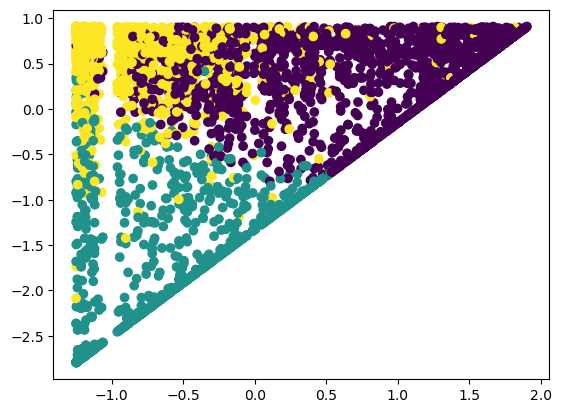

In [31]:
plt.scatter(customers["EarliestOrder"],customers["LatestOrder"],c=customers["Label"])

The amount spent (logarithmic) and earliest order date also show clear clustering.

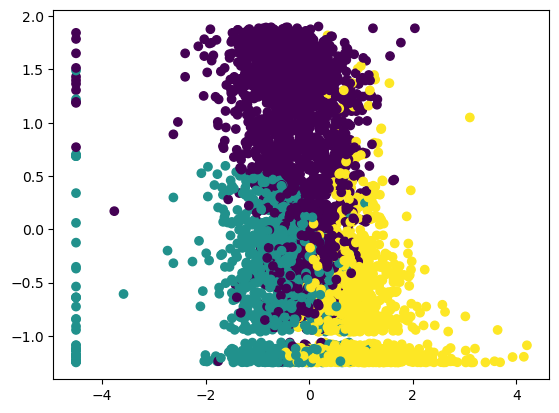

In [32]:
plt.scatter(customers["LogSpent"],customers["EarliestOrder"],c=customers["Label"])

With the number of unique products purchases and the total amount spent, one cluster can easily be distinguished from the other two, but the other two are hard to distinguish.

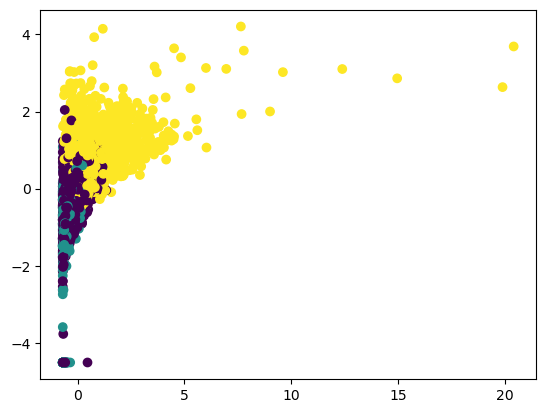

In [33]:
plt.scatter(customers["UniqueProducts"],customers["LogSpent"],c=customers["Label"])

With the number of unique orders and the earliest order date, again the yellow cluster is easily distinguished from the other two, but the other two are hard to distinguish.

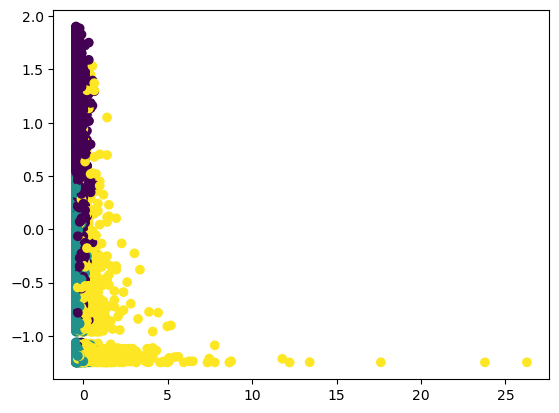

In [34]:
plt.scatter(customers["UniqueOrders"],customers["EarliestOrder"],c=customers["Label"])

# BIRCH Clustering

BIRCH is another clustering methods, described in the help file below. This section creates a far greater number of clusters. It appears that clusters with nearby numbers are related, which I don't think is the case for k-means.

In [45]:
help(Birch)

Help on class Birch in module sklearn.cluster._birch:

class Birch(sklearn.base.ClassNamePrefixFeaturesOutMixin, sklearn.base.ClusterMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  Birch(*, threshold=0.5, branching_factor=50, n_clusters=3, compute_labels=True, copy=True)
 |  
 |  Implements the BIRCH clustering algorithm.
 |  
 |  It is a memory-efficient, online-learning algorithm provided as an
 |  alternative to :class:`MiniBatchKMeans`. It constructs a tree
 |  data structure with the cluster centroids being read off the leaf.
 |  These can be either the final cluster centroids or can be provided as input
 |  to another clustering algorithm such as :class:`AgglomerativeClustering`.
 |  
 |  Read more in the :ref:`User Guide <birch>`.
 |  
 |  .. versionadded:: 0.16
 |  
 |  Parameters
 |  ----------
 |  threshold : float, default=0.5
 |      The radius of the subcluster obtained by merging a new sample and the
 |      closest subcluster should be lesser than t

`branching_factor` and `threshold` are default values. `n_clusters` has a default value of 3. Without a value specified, there is no final clustering step.

In [46]:
model=Birch(branching_factor=50, n_clusters=None, threshold=.5)
model.fit(customers.iloc[:,:-1])
pred=model.predict(customers.iloc[:,:-1])

In [47]:
# 517 clusters. That's a lot.
unique = len(np.unique(pred))
print("There are",unique,"clusters.")

There are 517 clusters.


In [48]:
counts = np.unique(pred,return_counts=True)[1]
max(counts)
# Returns 180. That means that the largest cluster has 180 instances, or about 4% of the total.

180

Despite the large number of clusters, it can be seen that nearly instances are more likely to have similar colors than would be the case with random clustering or arbitrary labels.

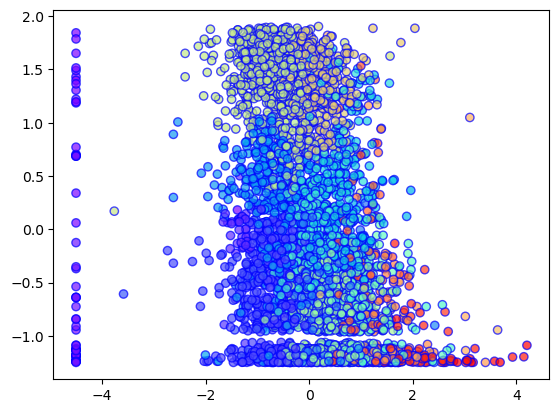

In [49]:
plt.scatter(x=customers["LogSpent"],y=customers["EarliestOrder"],c=pred,cmap='rainbow',alpha=0.7,edgecolors='b')

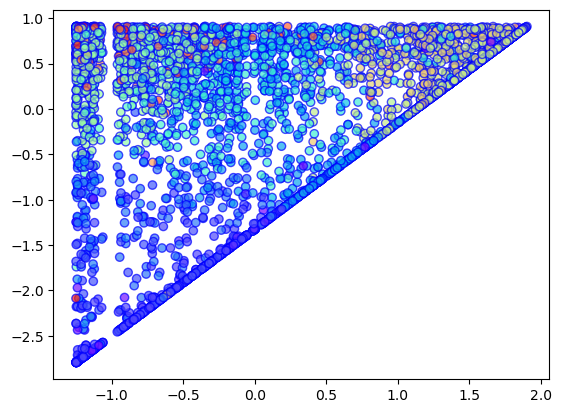

In [50]:
plt.scatter(x=customers["EarliestOrder"],y=customers["LatestOrder"],c=pred,cmap='rainbow',alpha=0.7,edgecolors='b')

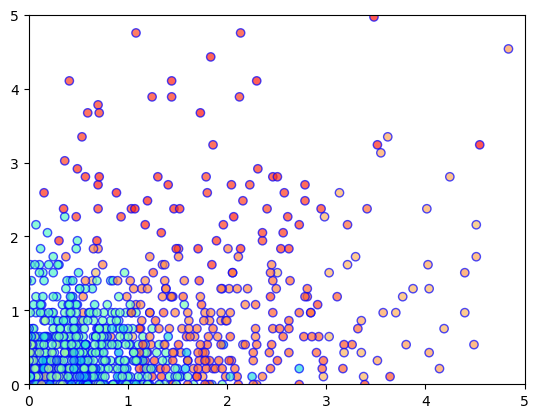

In [51]:
# Zooming in because some outliers would otherwise make the plot hard to read.
plt.scatter(x=customers["UniqueProducts"],y=customers["UniqueOrders"],c=pred,cmap='rainbow',alpha=0.7,edgecolors='b')
plt.xlim([0,5])
plt.ylim([0,5])
plt.show()